In [1]:
import os
current_directory = os.getcwd()

print("Текущая рабочая директория:", current_directory)

Текущая рабочая директория: /home/sh.aubakirov/NU&KBTU_data


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


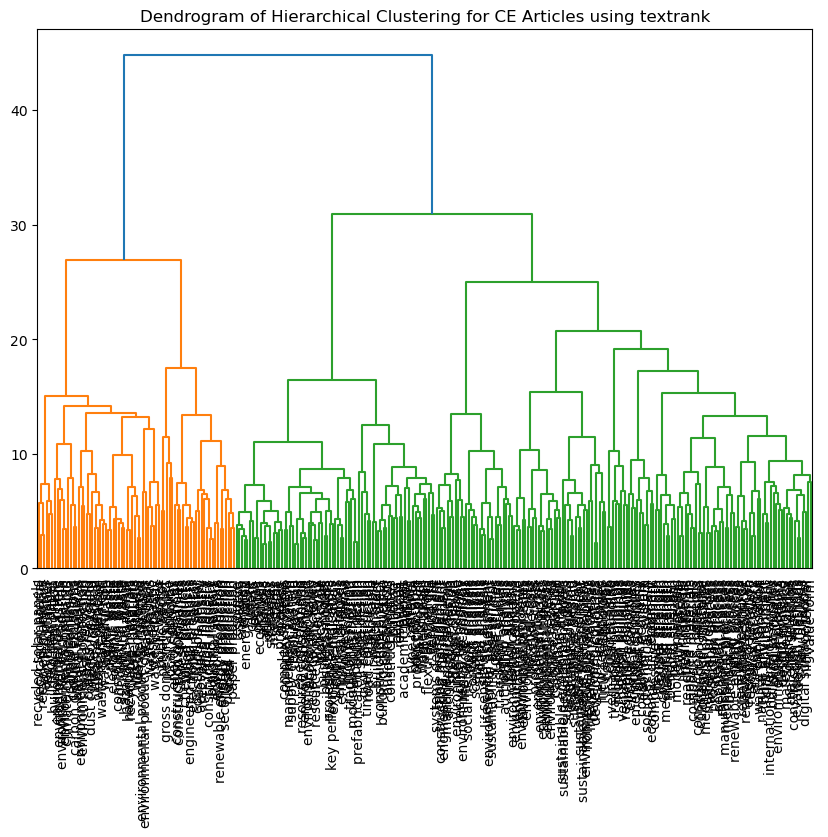

In [2]:
import pandas as pd
from transformers import BertModel, BertTokenizer
import torch
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
# Загрузка данных
area = 'CE' # CE or SC
approach = 'textrank' #textrank or tfidf
#file_path = "NU&KBTU_data/results_tfidf/f'ds_{area}_{approach}_terms.xlsx'"  # Укажите путь к файлу

file_path = f"/home/sh.aubakirov/NU&KBTU_data/results_{approach}/ds_{area}_{approach}_terms.xlsx"
data = pd.read_excel(file_path)

# Очистка данных
words_to_exclude = ['review', 'research']
mask = data['term'].apply(lambda x: any(word in x.lower() for word in words_to_exclude))
filtered_data = data[~mask]

# Загрузка предварительно обученной модели и токенизатора BERT
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def bert_encode(texts, model, tokenizer):
    """Функция для кодирования текстов с помощью BERT."""
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Используем только вектора последнего скрытого слоя
    return model_output.last_hidden_state[:, 0, :].numpy()

# Подготовка данных
terms = filtered_data['term'].tolist()

# Векторизация терминов
term_vectors = bert_encode(terms, model, tokenizer)

# Использование иерархической кластеризации
linked = linkage(term_vectors, 'ward')

# Визуализация дендрограммы
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=terms, leaf_rotation=90, leaf_font_size=10)
plt.title(f'Dendrogram of Hierarchical Clustering for {area} Articles using {approach}')


plt.savefig(f'dendrogram_{area}_{approach}.png') 

plt.show()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


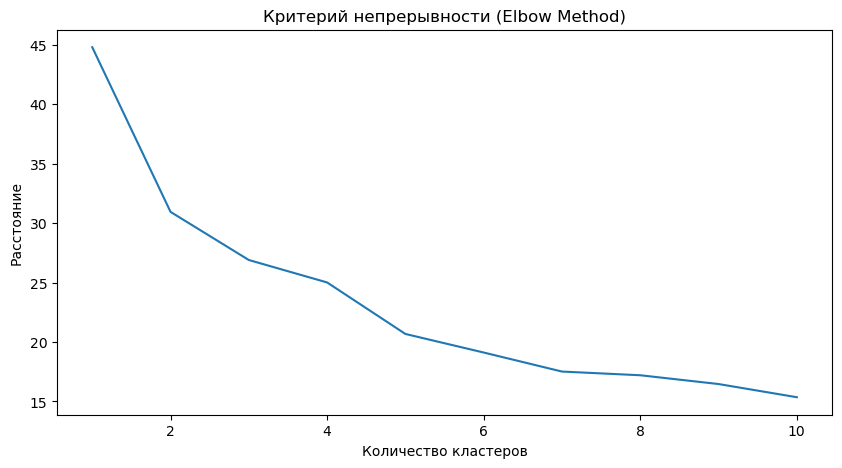

Cluster 1: ['construction waste', 'electronic waste', 'recycled material', 'recyclable materials', 'waste recycling', 'recycled materials', 'organic waste', 'waste hierarchy', 'plastics recycling', 'recycled plastics', 'agricultural waste', 'building demolition', 'environmental degradation', 'recycled timber', 'waste collection', 'wastes', 'waste products', 'waste generation', 'waste materials', 'paper waste', 'recycled paper', 'waste heat', 'environmental pollution', 'waste management', 'waste disposal', 'plastic waste', 'waste plastics', 'waste plastic', 'waste reduction', 'waste material', 'mining waste', 'carbon emissions', 'carbon dioxide emissions', 'carbon emission', 'natural resources', 'environmental disasters', 'hazardous material', 'hazardous materials', 'environmental crime', 'environmental information', 'climate change impacts', 'environmental product declaration', 'environmental product declarations', 'dust collection system', 'environmental protection', 'recycled solar p

In [4]:
import pandas as pd
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Загрузка и очистка данных
#data_path = 'ds_sc_textrank_terms.xlsx'
data = pd.read_excel(file_path)
words_to_exclude = ['review', 'research']
mask = data['term'].apply(lambda x: any(word in x.lower() for word in words_to_exclude))
filtered_data = data[~mask]
terms = filtered_data['term'].tolist()

# Инициализация BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Функция для кодирования текста
def bert_encode(texts, model, tokenizer):
    encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
    with torch.no_grad():
        outputs = model(**encoded_inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

def plot_elbow(linked):
    last = linked[-10:, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(idxs, last_rev)
    plt.title('Критерий непрерывности (Elbow Method)')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Расстояние')
    plt.show()
    
# Кодирование терминов и кластеризация
term_vectors = bert_encode(terms, model, tokenizer)
linked = linkage(term_vectors, 'ward')

plot_elbow(linked)

# Предположим, мы выбрали определенное число кластеров (например, k=5)
k = 5
assignments = fcluster(linked, k, criterion='maxclust')

# Разделение терминов по кластерам и вывод по 20 терминов из каждого кластера
clustered_terms = {}
for i in range(1, k+1):
    cluster_terms = [terms[j] for j in range(len(assignments)) if assignments[j] == i]
    clustered_terms[f'Cluster {i}'] = cluster_terms[:300] if len(cluster_terms) > 20 else cluster_terms

# Вывод терминов по кластерам
for cluster, terms in clustered_terms.items():
    print(f'{cluster}: {terms}\n')

In [5]:
# Создание текстового файла для записи кластеров и их терминов
output_file_path = f'clustered_terms_{area}_{approach}.txt'
with open(output_file_path, 'w') as file:
    for cluster, terms in clustered_terms.items():
        file.write(f'{cluster}: {terms}\n\n')

print("Файл сохранен по пути:", output_file_path)

Файл сохранен по пути: clustered_terms_CE_textrank.txt
